<a href="https://colab.research.google.com/github/angelinakhatiwada/Finding_Similar_Items_Spark/blob/main/Finding_similar_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding similar items**

### Project for the **Algorithms for massive data course**

*Angelina Khatiwada, \
MSc, Data Science and Economics*

December 2021

## Loading Kaggle Dataset and setting Spark environment

In [ ]:
# installing Kaggle library
# please upload your kaggle.json file with Kaggle API credentials manually to the files folder
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#dataset link: https://www.kaggle.com/stackoverflow/stacksample
! kaggle datasets download stackoverflow/stacksample

 99% 1.09G/1.11G [00:44<00:00, 19.4MB/s]
100% 1.11G/1.11G [00:44<00:00, 26.9MB/s]


In [ ]:
! unzip stacksample.zip

Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [ ]:
# installing and importing pyspark and other libraries
!pip install pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, countDistinct, udf, lower, regexp_replace, size
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, MinHashLSH, Normalizer
from pyspark.sql.types import DoubleType
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 59.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=7b0cc65d21b65452ebfe18948efb91a107ece23d7b25fc5da2fefc155aecf1c1
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
# setting Spark 3.2.0 environment
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"

#SparkSession initialization
conf = SparkConf().setAppName("similar_items")
spark = SparkSession.builder.enableHiveSupport().config(conf = conf).getOrCreate()
sc = spark.sparkContext
type(sc)

pyspark.context.SparkContext

In [ ]:
# reading table Questions
questions_df = spark.read.csv('Questions.csv', header=True, inferSchema=True, multiLine=True, escape='"',
                           encoding = "ISO-8859-1")

## Pre-processsing

### Exploratory analysis

In [ ]:
# Display schema and data sample
questions_df.printSchema()
print("Size of the DataFrame: {} records".format(questions_df.count()))

root
 |-- Id: integer (nullable = true)
 |-- OwnerUserId: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- ClosedDate: string (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)

Size of the DataFrame: 1264216 records


In [ ]:
questions_df.show(n = 10)

+---+-----------+-------------------+--------------------+-----+--------------------+--------------------+
| Id|OwnerUserId|       CreationDate|          ClosedDate|Score|               Title|                Body|
+---+-----------+-------------------+--------------------+-----+--------------------+--------------------+
| 80|         26|2008-08-01 13:57:07|                  NA|   26|SQLStatement.exec...|<p>I've written a...|
| 90|         58|2008-08-01 14:41:24|2012-12-26T03:45:49Z|  144|Good branching an...|<p>Are there any ...|
|120|         83|2008-08-01 15:50:08|                  NA|   21|   ASP.NET Site Maps|<p>Has anyone got...|
|180|    2089740|2008-08-01 18:42:19|                  NA|   53|Function for crea...|<p>This is someth...|
|260|         91|2008-08-01 23:22:08|                  NA|   49|Adding scripting ...|<p>I have a littl...|
|330|         63|2008-08-02 02:51:36|                  NA|   29|Should I use nest...|<p>I am working o...|
|470|         71|2008-08-02 15:11:47|

In [ ]:
#select columns Id, Title, Body
questions = questions_df.select("Id", "Title", "Body")
questions.show(n = 10)

+---+--------------------+--------------------+
| Id|               Title|                Body|
+---+--------------------+--------------------+
| 80|SQLStatement.exec...|<p>I've written a...|
| 90|Good branching an...|<p>Are there any ...|
|120|   ASP.NET Site Maps|<p>Has anyone got...|
|180|Function for crea...|<p>This is someth...|
|260|Adding scripting ...|<p>I have a littl...|
|330|Should I use nest...|<p>I am working o...|
|470|Homegrown consump...|<p>I've been writ...|
|580|Deploying SQL Ser...|<p>I wonder how y...|
|650|Automatically upd...|<p>I would like t...|
|810|Visual Studio Set...|<p>I'm trying to ...|
+---+--------------------+--------------------+
only showing top 10 rows



In [ ]:
type(questions)

pyspark.sql.dataframe.DataFrame

In [ ]:
#check if there are missing values in the columns - no missing values
questions.select([count(when(isnan(c), c)).alias(c) for c in questions.columns]).show()

+---+-----+----+
| Id|Title|Body|
+---+-----+----+
|  0|    0|   0|
+---+-----+----+



In [ ]:
#count distinct values in each column
questions.select([countDistinct(c).alias(c) for c in questions.columns]).show()

+-------+-------+-------+
|     Id|  Title|   Body|
+-------+-------+-------+
|1264216|1263995|1264204|
+-------+-------+-------+



### Duplicates check

In [ ]:
# show duplicates in Body column
questions.groupBy("Body").count().filter("count > 1").show()

+--------------------+-----+
|                Body|count|
+--------------------+-----+
|<p>How I can disp...|    2|
|<p>I'm attempting...|    2|
|<p>I got problem ...|    2|
|<p>I have Some Pa...|    2|
|<p>I'm working on...|    2|
|<p>I am using MS ...|    2|
|<p>PayPal IPN sen...|    2|
|<p>Is it possible...|    2|
|<p>Anyone know ho...|    2|
|<p>I am trying to...|    2|
|<p>How can I use ...|    2|
|<p>When I tried t...|    2|
+--------------------+-----+



In [ ]:
# show duplicates in Body that are also duplicates in Title
questions.groupBy( "Body", "Title").count().filter("count > 1").show()

+--------------------+--------------------+-----+
|                Body|               Title|count|
+--------------------+--------------------+-----+
|<p>I am trying to...|Android: BitmapDr...|    2|
|<p>PayPal IPN sen...|Cannot send value...|    2|
+--------------------+--------------------+-----+



In [ ]:
questions_duplicate = questions.join(questions.groupBy('Body')\
                               .count().where('count = 1').drop('count'),
                                on=['Body'],
                                how='left_anti')

In [ ]:
questions_duplicate2 = questions.join(questions.groupBy('Title', 'Body')\
                               .count().where('count = 1').drop('count'),
                                on=['Title', 'Body'],
                                how='left_anti')

In [ ]:
# 12 pairs of duplicates in Body column
questions_duplicate.show(questions_duplicate.count())

+--------------------+--------+--------------------+
|                Body|      Id|               Title|
+--------------------+--------+--------------------+
|<p>How I can disp...|30993210|dompdf - display ...|
|<p>How I can disp...|31037750|How to determine ...|
|<p>I'm attempting...| 3400470|Create a smooth f...|
|<p>I'm attempting...| 6426300|Android: Smooth f...|
|<p>I got problem ...|30128150|Can not find post...|
|<p>I got problem ...|30138690|Can not connect w...|
|<p>I have Some Pa...| 6744140|Store JavaScript ...|
|<p>I have Some Pa...| 6744970|Store JavaScript ...|
|<p>I'm working on...|38120120|Inserting to sort...|
|<p>I'm working on...|38124500|Inserting element...|
|<p>I am using MS ...|23876060|ODBC SQL Server D...|
|<p>I am using MS ...|24001180|ODBC SQL Server D...|
|<p>PayPal IPN sen...| 2807730|Cannot send value...|
|<p>PayPal IPN sen...| 2808090|Cannot send value...|
|<p>Anyone know ho...|23401620|how to open and r...|
|<p>Anyone know ho...|23403060|How to read the

In [ ]:
# 2 pairs of dupicates in Title and Body columns
questions_duplicate2.show(questions_duplicate2.count())

+--------------------+--------------------+-------+
|               Title|                Body|     Id|
+--------------------+--------------------+-------+
|Android: BitmapDr...|<p>I am trying to...|5087720|
|Android: BitmapDr...|<p>I am trying to...|5090290|
|Cannot send value...|<p>PayPal IPN sen...|2807730|
|Cannot send value...|<p>PayPal IPN sen...|2808090|
+--------------------+--------------------+-------+



### Text cleaning and pre-processing

In [ ]:
#select Id, Body columns
# Only Body column is used for the further analysis
questions_body = questions.select("Id", "Body")
questions_body.show(n = 10)

+---+--------------------+
| Id|                Body|
+---+--------------------+
| 80|<p>I've written a...|
| 90|<p>Are there any ...|
|120|<p>Has anyone got...|
|180|<p>This is someth...|
|260|<p>I have a littl...|
|330|<p>I am working o...|
|470|<p>I've been writ...|
|580|<p>I wonder how y...|
|650|<p>I would like t...|
|810|<p>I'm trying to ...|
+---+--------------------+
only showing top 10 rows



Only questions body is used to find similar questions, so the title is removed from the further analysis. The following text transformations are applied:
1. Transforming text to lowercase
2. Removing html tagging
3. Remove numbers
4. Removing punctuation 
5. Text tokenization
6. Removing stopwords

In [ ]:
# cleaning the text
def clean_text(text):
  text = lower(text)
  text = regexp_replace(text, "<[^>]*>", "")
  text = regexp_replace(text, "[^a-zA-Z\\s]", "")
  return text

In [ ]:
clean_questions = questions_body.select('Id', clean_text(col("Body")).alias("Body"))
clean_questions.show(10)

+---+--------------------+
| Id|                Body|
+---+--------------------+
| 80|ive written a dat...|
| 90|are there any rea...|
|120|has anyone got ex...|
|180|this is something...|
|260|i have a little g...|
|330|i am working on a...|
|470|ive been writing ...|
|580|i wonder how you ...|
|650|i would like the ...|
|810|im trying to main...|
+---+--------------------+
only showing top 10 rows



In [ ]:
# text tokenization
tokenizer = Tokenizer().setInputCol("Body").setOutputCol("Tokens")
tokenized = tokenizer.transform(clean_questions)
tokenized.show(10)

+---+--------------------+--------------------+
| Id|                Body|              Tokens|
+---+--------------------+--------------------+
| 80|ive written a dat...|[ive, written, a,...|
| 90|are there any rea...|[are, there, any,...|
|120|has anyone got ex...|[has, anyone, got...|
|180|this is something...|[this, is, someth...|
|260|i have a little g...|[i, have, a, litt...|
|330|i am working on a...|[i, am, working, ...|
|470|ive been writing ...|[ive, been, writi...|
|580|i wonder how you ...|[i, wonder, how, ...|
|650|i would like the ...|[i, would, like, ...|
|810|im trying to main...|[im, trying, to, ...|
+---+--------------------+--------------------+
only showing top 10 rows



In [ ]:
# counting the number of tokens
tokenized = tokenized.withColumn("Number of tokens", size(tokenized['Tokens']))
tokenized.show(5)

+---+--------------------+--------------------+----------------+
| Id|                Body|              Tokens|Number of tokens|
+---+--------------------+--------------------+----------------+
| 80|ive written a dat...|[ive, written, a,...|             349|
| 90|are there any rea...|[are, there, any,...|              24|
|120|has anyone got ex...|[has, anyone, got...|              58|
|180|this is something...|[this, is, someth...|              41|
|260|i have a little g...|[i, have, a, litt...|             181|
+---+--------------------+--------------------+----------------+
only showing top 5 rows



In [ ]:
# removing stopwords using default list
remove_stopwords = StopWordsRemover()
stopwords = remove_stopwords.getStopWords() 
print(stopwords[:10])
print(len(stopwords))

remove_stopwords.setInputCol("Tokens").setOutputCol("Tokens stopwords removed")
tokenized_clean = remove_stopwords.transform(tokenized)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']
181


In [ ]:
# counting the number of tokens with stopwords removed
tokenized_clean = tokenized_clean.withColumn("Number of tokens stopwords removed", size(tokenized_clean['Tokens stopwords removed']))
tokenized_clean.show(10)

+---+--------------------+--------------------+----------------+------------------------+----------------------------------+
| Id|                Body|              Tokens|Number of tokens|Tokens stopwords removed|Number of tokens stopwords removed|
+---+--------------------+--------------------+----------------+------------------------+----------------------------------+
| 80|ive written a dat...|[ive, written, a,...|             349|    [ive, written, da...|                               317|
| 90|are there any rea...|[are, there, any,...|              24|    [really, good, tu...|                                14|
|120|has anyone got ex...|[has, anyone, got...|              58|    [anyone, got, exp...|                                40|
|180|this is something...|[this, is, someth...|              41|    [something, ive, ...|                                21|
|260|i have a little g...|[i, have, a, litt...|             181|    [little, game, wr...|                                96|


In [ ]:
#select columns Id, "Tokens stopwords removed"
questions_final = tokenized_clean.select("Id", "Tokens stopwords removed")
questions_final.show(n = 10)

+---+------------------------+
| Id|Tokens stopwords removed|
+---+------------------------+
| 80|    [ive, written, da...|
| 90|    [really, good, tu...|
|120|    [anyone, got, exp...|
|180|    [something, ive, ...|
|260|    [little, game, wr...|
|330|    [working, collect...|
|470|    [ive, writing, we...|
|580|    [wonder, guys, ma...|
|650|    [like, version, p...|
|810|    [im, trying, main...|
+---+------------------------+
only showing top 10 rows



In [ ]:
# remove empty rows 
questions_final_filtered = questions_final.where((size(col("Tokens stopwords removed")) >= 1))
#questions_final_filtered.count()

## Feature extraction and similarity analysis

In [ ]:
# creating list of chunk sizes
a = 100
sample_size = []
for i in range(0,11):
    sample_size.append(a)
    a = a*2
sample_size

[100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400]

#### TF + MinHash

In [ ]:
computation_time_tf = []
for size in sample_size:
  # set up a timer
  start = time.time()

  print('Size: ' + str(size))

  # limit number of columns for analysis
  questions_final_limited = questions_final_filtered.limit(size)

  # computing TF
  hashingTF = HashingTF(inputCol="Tokens stopwords removed", outputCol="TF", numFeatures=1024)
  tf = hashingTF.transform(questions_final_limited)

  # computing MinHash 
  mh = MinHashLSH(inputCol="TF", outputCol="hashes", seed = 3)
  model = mh.fit(tf)
  hash = model.transform(tf)

  # computing the locality sensitive hashes and performing approximate similarity join
  print("Approximately joining on distance smaller than 0.6, duplicate ids removed:")
  result = model.approxSimilarityJoin(hash, hash, 0.6, distCol="JaccardDistance")\
              .select(col("datasetA.id").alias("id1"),
              col("datasetB.id").alias("id2"),
              col("JaccardDistance")).filter('id1 < id2')
              
  # showing id pairs with distance < 0.6 sorted in ascending order
  result.sort(result.JaccardDistance.asc()).show(10)

  #stop the timer
  end = time.time()

  computation_time = round(end - start, 3)
  print("Computation time: {} seconds".format(round(end - start, 3)))

  computation_time_tf.append(computation_time)

  print('------------------------------------')

Size: 100
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 1.081 seconds
------------------------------------
Size: 200
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 1.186 seconds
------------------------------------
Size: 400
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 1.344 seconds
------------------------------------
Size: 800
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 1.726 seconds
-

In [ ]:
computation_time_tf

[1.081,
 1.186,
 1.344,
 1.726,
 3.026,
 5.552,
 14.212,
 43.078,
 140.837,
 499.194,
 1862.97]

In [ ]:
hash.show()

+----+------------------------+--------------------+----------------+
|  Id|Tokens stopwords removed|                  TF|          hashes|
+----+------------------------+--------------------+----------------+
|  80|    [ive, written, da...|(1024,[3,6,11,40,...|   [[2078511.0]]|
|  90|    [really, good, tu...|(1024,[65,80,348,...|  [[5.527494E7]]|
| 120|    [anyone, got, exp...|(1024,[19,39,88,9...| [[3.0469636E7]]|
| 180|    [something, ive, ...|(1024,[9,17,105,1...|   [[2703620.0]]|
| 260|    [little, game, wr...|(1024,[43,53,58,7...| [[8.2415847E7]]|
| 330|    [working, collect...|(1024,[77,79,108,...|   [[2703620.0]]|
| 470|    [ive, writing, we...|(1024,[29,58,70,1...| [[4.9813792E7]]|
| 580|    [wonder, guys, ma...|(1024,[0,35,39,56...| [[1.6586628E7]]|
| 650|    [like, version, p...|(1024,[3,4,23,53,...| [[6.0110979E7]]|
| 810|    [im, trying, main...|(1024,[47,58,71,8...| [[2.2047776E7]]|
| 930|    [whats, simplest,...|(1024,[58,153,168...| [[8.2415847E7]]|
|1010|    [need, gra

In [ ]:
hash.first()['TF']

SparseVector(1024, {3: 1.0, 6: 1.0, 11: 1.0, 40: 1.0, 56: 1.0, 58: 1.0, 59: 1.0, 93: 1.0, 107: 1.0, 112: 1.0, 120: 2.0, 138: 1.0, 151: 1.0, 153: 2.0, 160: 1.0, 165: 1.0, 188: 2.0, 206: 1.0, 228: 2.0, 230: 1.0, 233: 1.0, 246: 1.0, 271: 1.0, 274: 1.0, 308: 2.0, 319: 1.0, 320: 1.0, 323: 1.0, 336: 1.0, 341: 2.0, 344: 1.0, 348: 189.0, 357: 1.0, 360: 2.0, 363: 3.0, 393: 2.0, 419: 1.0, 426: 2.0, 439: 4.0, 452: 2.0, 461: 1.0, 489: 1.0, 492: 3.0, 493: 1.0, 516: 1.0, 537: 1.0, 544: 1.0, 560: 1.0, 569: 1.0, 582: 1.0, 595: 5.0, 603: 1.0, 610: 1.0, 613: 1.0, 639: 2.0, 648: 1.0, 661: 5.0, 674: 1.0, 681: 1.0, 684: 3.0, 688: 1.0, 708: 1.0, 731: 3.0, 736: 1.0, 745: 3.0, 777: 1.0, 782: 2.0, 798: 1.0, 801: 3.0, 806: 8.0, 813: 1.0, 816: 1.0, 823: 1.0, 836: 2.0, 859: 1.0, 860: 1.0, 868: 1.0, 902: 1.0, 908: 1.0, 920: 1.0, 927: 1.0, 936: 1.0, 961: 1.0, 986: 1.0, 989: 1.0, 1015: 1.0})

In [ ]:
hash.first()['hashes']

[DenseVector([2078511.0])]

In [ ]:
# examples of similar questions detected
questions_df.filter( (questions_df.Id  == 2311160) | (questions_df.Id  == 4115730) ) \
    .show(truncate=False)

+-------+-----------+-------------------+----------+-----+------------------------------------------------------------------+-----------------------------+
|Id     |OwnerUserId|CreationDate       |ClosedDate|Score|Title                                                             |Body                         |
+-------+-----------+-------------------+----------+-----+------------------------------------------------------------------+-----------------------------+
|2311160|116875     |2010-02-22 13:39:40|NA        |0    |Is There a way to update/refresh only one record in delphi dbgrid?|<p>Is it possible? How?</p>\n|
|4115730|495315     |2010-11-06 23:31:27|NA        |0    |Iphone simulator without iphone SDK?                              |<p>Is it possible?</p>\n     |
+-------+-----------+-------------------+----------+-----+------------------------------------------------------------------+-----------------------------+



In [ ]:
# examples of the similar questions detected
questions_df.filter( (questions_df.Id  == 3669960) | (questions_df.Id  == 3676110) ) \
    .show(truncate=False)

+-------+-----------+-------------------+----------+-----+--------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id     |OwnerUserId|CreationDate       |ClosedDate|Score|Title                                                   |Body                                                                                                                                                                                                                                                                                                                                             

In [ ]:
# examples of the similar questions detected
questions_df.filter( (questions_df.Id  == 2807730) | (questions_df.Id  == 2808090) ) \
    .show(truncate=False)

+-------+-----------+-------------------+----------+-----+---------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id     |OwnerUserId|CreationDate       |ClosedDate|Score|Title                      |Body                                                                                                                                                                                                                                                                                                                                                                                          

#### TF-IDF + MinHash

In [ ]:
computation_time_tf_idf = []
for size in sample_size:
  # set up a timer
  start = time.time()

  print('Size: ' + str(size))

  # limit number of columns for analysis
  questions_final_limited = questions_final_filtered.limit(size)

  # computing TF - IDF
  hashingTF = HashingTF(inputCol="Tokens stopwords removed", outputCol="TF", numFeatures=1024)
  tf = hashingTF.transform(questions_final_limited)

  idf = IDF(inputCol="TF", outputCol="TF-IDF")
  idfModel = idf.fit(tf)
  tfidf = idfModel.transform(tf)

  # computing MinHash 
  mh = MinHashLSH(inputCol="TF-IDF", outputCol="hashes", seed = 3)
  model = mh.fit(tfidf)
  hash = model.transform(tfidf)

  # computing the locality sensitive hashes and performing approximate similarity join
  print("Approximately joining on distance smaller than 0.6, duplicate ids removed:")
  result = model.approxSimilarityJoin(hash, hash, 0.6, distCol="JaccardDistance")\
              .select(col("datasetA.id").alias("id1"),
              col("datasetB.id").alias("id2"),
              col("JaccardDistance")).filter('id1 < id2')
              
  # showing id pairs with distance < 0.6 sorted in ascending order
  result.sort(result.JaccardDistance.asc()).show(10)

  #stop the timer
  end = time.time()

  computation_time = round(end - start, 3)
  print("Computation time: {} seconds".format(round(end - start, 3)))

  computation_time_tf_idf.append(computation_time)

  print('------------------------------------')

Size: 100
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 1.753 seconds
------------------------------------
Size: 200
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 1.823 seconds
------------------------------------
Size: 400
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 2.24 seconds
------------------------------------
Size: 800
Approximately joining on distance smaller than 0.6, duplicate ids removed:
+---+---+---------------+
|id1|id2|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation time: 3.103 seconds
--

In [ ]:
computation_time_tf_idf

[1.753,
 1.823,
 2.24,
 3.103,
 5.626,
 8.551,
 19.299,
 54.097,
 162.047,
 548.943,
 3336.834]

#### TF + cosine similarity join (full scan)

In [ ]:
# define cosine similarity as a dot product of 2 vectors
dot_udf = udf(lambda x,y: float(x.dot(y)), DoubleType())

In [ ]:
# set a new chunk size list
sample_size2 = [100, 200, 400, 800, 1600, 3200]

computation_time_tf_cosine = []
for size in sample_size2:
  # set up a timer
  start = time.time()

  print('Size: ' + str(size))

  start = time.time()

  # limit number of columns for analysis
  questions_final_limited = questions_final_filtered.limit(size)

  # computing TF
  hashingTF = HashingTF(inputCol="Tokens stopwords removed", outputCol="TF", numFeatures=1024)
  tf = hashingTF.transform(questions_final_limited)

  # normalizing
  normalizer = Normalizer(inputCol="TF", outputCol="TF_norm", p=1.0)
  tf_norm = normalizer.transform(tf)

  print("Joining on cosine distance, duplicate ids removed:")
  result = tf_norm.alias("i").join(tf_norm.alias("j"), col("i.Id") < col("j.Id"))\
                        .select(
                            col("i.Id").alias("i_Id"), 
                            col("j.Id").alias("j_Id"), 
                            dot_udf("i.TF_norm", "j.TF_norm").alias("cosine_similarity"))\
                        .sort("i_Id", "j_Id")

  # showing id pairs sorted in descending order (similarity)
  result.sort(result.cosine_similarity.desc()).show(10)

  #stop the timer
  end = time.time()

  computation_time = round(end - start, 3)
  print("Computation time: {} seconds".format(round(end - start, 3)))

  computation_time_tf_cosine.append(computation_time)

  print('------------------------------------')

Size: 100
Joining on cosine distance, duplicate ids removed:
+----+----+-------------------+
|i_Id|j_Id|  cosine_similarity|
+----+----+-------------------+
|  80|6110|0.39837252652710053|
|6110|8800| 0.3804300920598389|
|5260|6110|0.34034706824340966|
|  80|8800| 0.3402946931278201|
|  80|5260| 0.3045403640156275|
|2780|6110| 0.2945772058823529|
|5260|8800|  0.290436005625879|
|2900|6110|0.27213879870129865|
|6110|6340|  0.271934227433344|
|  80|2780|  0.263082204490629|
+----+----+-------------------+
only showing top 10 rows

Computation time: 2.429 seconds
------------------------------------
Size: 200
Joining on cosine distance, duplicate ids removed:
+-----+-----+-------------------+
| i_Id| j_Id|  cosine_similarity|
+-----+-----+-------------------+
|13160|13620|0.49465364946536494|
| 6110|13620|0.47686688311688313|
|13620|16340| 0.4767365661861075|
|13160|16340|0.46241986871905105|
| 6110|13160|0.46240252947888927|
| 6110|16340|  0.445703450792327|
|   80|13620| 0.4258675078864

In [ ]:
# examples of similar questions detected
questions_df.filter( (questions_df.Id  == 187000) | (questions_df.Id  == 198320) ) \
    .show(truncate=False)

+------+-----------+-------------------+----------+-----+--------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
computation_time_tf_cosine = computation_time_tf_cosine + [0,0,0,0,0]
computation_time_tf_cosine

[2.429, 6.711, 22.766, 86.999, 340.88, 1362.607, 0, 0, 0, 0, 0]

### Algorithms performance comparison

In [ ]:
# create a dataframe chunk size - running time
import pandas as pd
import numpy as np
results_time = pd.DataFrame(
    {'Dataset_size': sample_size,
     'Computation_time_TF_LSH': computation_time_tf,
     'Computation_time_TFIDF_LSH': computation_time_tf_idf,
     'Computation_time_TF_cosine': computation_time_tf_cosine,
    })
results_time = results_time.replace(0, np.nan)

In [ ]:
results_time

,Dataset_size,Computation_time_TF_LSH,Computation_time_TFIDF_LSH,Computation_time_TF_cosine
0,100,1.081,1.753,2.429
1,200,1.186,1.823,6.711
2,400,1.344,2.240,22.766
3,800,1.726,3.103,86.999
4,1600,3.026,5.626,340.880
5,3200,5.552,8.551,1362.607
6,6400,14.212,19.299,NaN
7,12800,43.078,54.097,NaN
8,25600,140.837,162.047,NaN
9,51200,499.194,548.943,NaN


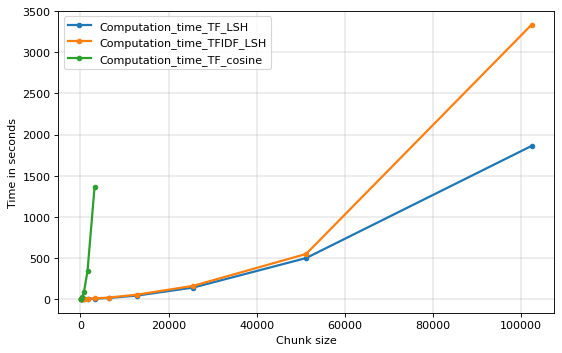

In [ ]:
# plotting running time against chunk size
plt.figure(figsize=(8,5), dpi=80)
plt.grid(linestyle='-', linewidth=0.4)

plt.plot(results_time['Dataset_size'], results_time['Computation_time_TF_LSH'], label = 'Computation_time_TF_LSH', linewidth=2, marker = 'o', markersize =4) 
plt.plot(results_time['Dataset_size'], results_time['Computation_time_TFIDF_LSH'], label = "Computation_time_TFIDF_LSH", linewidth=2, marker = 'o', markersize =4)
plt.plot(results_time['Dataset_size'], results_time['Computation_time_TF_cosine'], label = "Computation_time_TF_cosine", linewidth=2, marker = 'o', markersize =4)
plt.legend()
    
# naming the x axis 
plt.xlabel('Chunk size') 
# naming the y axis 
plt.ylabel('Time in seconds') 
   
plt.show() 

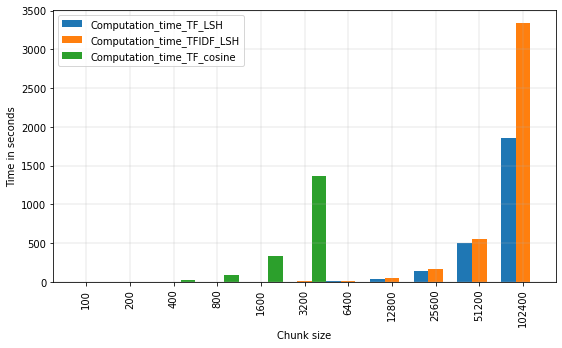

In [ ]:
fig, ax = plt.subplots()

results_time.plot.bar(x='Dataset_size', ax=ax, figsize=(9,5), width=1)
plt.grid(linestyle='-', linewidth=0.3)
plt.xlabel('Chunk size') 
plt.ylabel('Time in seconds') 
plt.show()

In [ ]:
# predicting time required to run Algorithm 1: TF + MinHash on the entire dataset using Polynomial regression (degrees: 1,2,3,4)
lin_reg = LinearRegression()
x = np.array(results_time['Dataset_size'])
x = x.reshape(-1, 1)

for deg in [1,2,3,4]:
# Fitting Polynomial Regression to the dataset
  poly_reg = PolynomialFeatures(degree=deg)
  X_poly = poly_reg.fit_transform(x)
  pol_reg = LinearRegression()
  pol_reg.fit(X_poly, results_time['Computation_time_TF_LSH'])
# Predicting with Polymonial Regression
  prediction = pol_reg.predict(poly_reg.fit_transform([[1264216]]))
# print(prediction[0])
  time_required = datetime.timedelta(seconds=prediction[0])
  print(str(deg) + str (' degree polynomial: ')+ str(time_required))

1 degree polynomial: 5:56:21.965272
2 degree polynomial: 3 days, 1:49:37.655261
3 degree polynomial: 2 days, 11:15:32.017143
4 degree polynomial: 240 days, 17:03:36.651973
